In [1]:
# TODO:
# reproducible results driven by seed
# correlation of features output for two networks. Or even FC training from from to other with L1/L2 norm?
# start develop liveconv
# don't forger penalise for operation, not (just) weight. Add stats on operations
# why features' weights small but not zero? should I try depth-separable conv?
# manual livenet for cifar10, and then think on auto?

%load_ext autoreload
%autoreload 2
import torch
import torch.utils
import torch.utils.data
import torchsummary
import numpy as np
import gc
from livenet.utils import set_seed
import onnx
import livenet
device = "cuda"
#device = "cpu"
#torch.set_default_device(device)
from ai_libs.simple_log import LOG


In [2]:
batch_size = 256
from livenet.datasets import TransformDataset
test_x, test_y = livenet.datasets.get_cifar10_test()
test = torch.utils.data.TensorDataset(test_x, test_y)
test_aug = TransformDataset(test, livenet.datasets.cifar10_test_transform)
test_loader = torch.utils.data.DataLoader(test_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=4, pin_memory=True)

train_x, train_y = livenet.datasets.get_cifar10_train()
train = torch.utils.data.TensorDataset(train_x, train_y)
train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)
train_loader = torch.utils.data.DataLoader(train_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=16, pin_memory=True, prefetch_factor=2)



KeyboardInterrupt: 

In [3]:

train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)


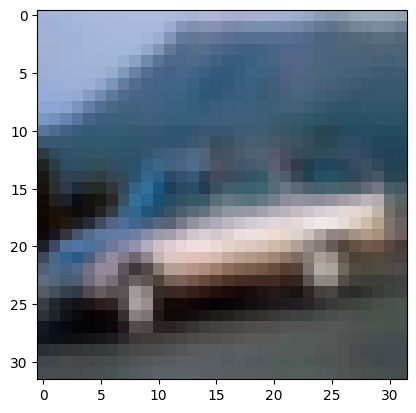

In [19]:
img = train_aug[4][0].numpy()
img = img.transpose(1, 2, 0)
from matplotlib import pyplot as plt
#img = livenet.datasets._elastic_transform(img, (-4, 0))
img = (img * 128 + 127).astype(np.uint8)

#plt.imsave("/home/spometun/img.png", img)
plt.imshow( img )

In [20]:
from cifar_arch import EffNet, ResNet9, ResNet9Small

set_seed(2)

# network = EffNet(device)
network = ResNet9Small(3, 10, device)
torchsummary.summary(network, (3, 32, 32), device=device)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
             ReLU6-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
            ReLU6-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
      BatchNorm2d-12           [-1, 32, 16, 16]              64
            ReLU6-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

In [182]:
np.set_printoptions(precision=3, suppress=True)
ax_in = (0, 2, 3)
ax_out = (1, 2, 3)
ax = ax_out
vals = list(network.parameters())[32].data.cpu().numpy()
vals_ref = list(network.parameters())[32].data
out_max = np.max(vals, axis=ax)
out_min = np.min(vals, axis=ax)
sign = -out_min > out_max
out = np.max(np.abs(vals), axis=ax)
#out *= 1 - sign * 2
LOG(f"{np.min(vals):.2f} {np.max(vals):.2f}")
print(np.sum(np.abs(vals) < 0.01), np.sum(np.abs(vals) > 0.0))
#vals_ref[np.abs(vals) < 0.05] = 0.0
out

Iˈ0.000 -0.43 0.75 
16 32


array([0.   , 0.281, 0.367, 0.   , 0.367, 0.409, 0.237, 0.429, 0.   ,
       0.204, 0.   , 0.   , 0.   , 0.   , 0.205, 0.   , 0.324, 0.   ,
       0.322, 0.54 , 0.   , 0.276, 0.313, 0.   , 0.   , 0.63 , 0.   ,
       0.753, 0.191, 0.   , 0.   , 0.   ], dtype=float32)

In [22]:
criterion = livenet.nets.criterion_classification_n
optimizer = livenet.nets.create_optimizer(network)
trainer = livenet.net_trainer.NetTrainer(network, train_loader, criterion, optimizer)
trainer.adaptive_lr = True
optimizer.learning_rate = 0.0025



Adam


In [177]:
network.train()
trainer.optimizer.learning_rate = 0.01 / 2 / 2 / 2 / 2 / 2 /2/2
network._alpha = 10 * 1e-6
trainer.step(1000)


Iˈ0.000 165749 0.700+0.598reg params=36 lr=0.00008 livenet/net_trainer.py:134
Iˈ6.852 165944 0.667+0.586reg params=36 lr=0.00008 livenet/net_trainer.py:134
Iˈ13.874 166139 0.659+0.580reg params=36 lr=0.00008 livenet/net_trainer.py:134
Iˈ21.046 166334 0.661+0.574reg params=36 lr=0.00008 livenet/net_trainer.py:134
Iˈ28.274 166529 0.652+0.570reg params=36 lr=0.00008 livenet/net_trainer.py:134


In [178]:
gc.collect()
torch.cuda.empty_cache()

def _infer_epoch(network, loader):
    preds = []
    ys = []
    with torch.no_grad():
        for x, y in iter(loader):
            x = x.to(network.device)
            pred = network(x)
            pred = pred.cpu()
            preds.append(pred)
            ys.append(y.cpu())
    pred = torch.concatenate(preds)
    y = torch.concatenate(ys)
    return pred, y


network.train()
#train_pred, train_labels = _infer_epoch(network, train_loader)
test_pred, test_labels = _infer_epoch(network, test_loader)

network.eval()
test_pred, test_labels = _infer_epoch(network, test_loader)
train_pred, train_labels = _infer_epoch(network, train_loader)

def calc_accuracy(predictions, labels):
    _, predicted = torch.max(predictions.data, 1)
    labels = labels.numpy()
    labels = np.squeeze(labels, 1)
    predicted = predicted.numpy()
    correct = np.sum(predicted == labels)
    total = len(labels)
    accuracy = correct / total
    return accuracy


# test_y_tensor = torch.tensor(test_y, device="cpu")
# train_y_tensor = torch.tensor(train_y, device="cpu")
test_loss = trainer.criterion(test_pred, test_labels).item()
train_loss = trainer.criterion(train_pred, train_labels).item()
LOG(f"loss: train: {train_loss:.3f} test: {test_loss:.3f}")

test_accuracy = calc_accuracy(test_pred, test_labels)
train_accuracy = calc_accuracy(train_pred, train_labels)
LOG(f"accuracy, train: {100 * train_accuracy:.1f}% test: {100 * test_accuracy:.1f}%")

Iˈ0.000 loss: train: 0.732 test: 0.468 
Iˈ0.001 accuracy, train: 82.8% test: 89.0% 


In [ ]:
network.to("cpu")

In [179]:
param = list(network.named_parameters())
param0 = list(network.parameters())


In [236]:
w = param[12][1].detach().cpu().numpy()
m = np.max(np.abs(w), axis=(1, 2, 3))
f"{int(100 * np.sum(m > 0.01) / len(m))}%"
np.sum(m > 0.01)

np.int64(12)

In [180]:
outs = dict()
for i in range(11):
    ind = i * 4
    if ind >= 36:
        ind = 32 + (i - 8)
    w = param[ind][1].detach().cpu().numpy()
    w_name = param[ind][0]
    m_out = np.max(np.abs(w), axis=(1, 2, 3))
    outs[ind] = m_out > 0.01
    m_in = np.max(np.abs(w), axis=(0, 2, 3))
    n_out = np.sum(m_out > 0.01)
    n_in = np.sum(m_in > 0.01)
    s = f"{w_name} {ind}, {w.shape} {int(100 * np.sum(m_out > 0.01) / len(m_out))}%, {n_in}->{n_out}"
    print(s)
for ind in [12, 28]:
    ind2 = 32 if ind == 12 else 33
    n_inter = np.sum(outs[ind] * outs[ind2])
    print(f"{ind} inter={n_inter}")


conv1.0.weight 0, (16, 3, 3, 3) 56%, 3->9
conv2.0.weight 4, (32, 16, 3, 3) 65%, 9->21
res1.0.0.weight 8, (32, 32, 3, 3) 34%, 21->11
res1.1.0.weight 12, (32, 32, 3, 3) 37%, 11->12
conv3.0.weight 16, (64, 32, 3, 3) 59%, 21->38
conv4.0.weight 20, (128, 64, 3, 3) 82%, 38->106
res2.0.0.weight 24, (128, 128, 3, 3) 100%, 106->128
res2.1.0.weight 28, (128, 128, 3, 3) 44%, 128->57
pick2.weight 32, (32, 1, 1, 1) 50%, 1->16
pick4.weight 33, (128, 1, 1, 1) 1%, 1->2
classifier.1.weight 34, (10, 128, 1, 1) 100%, 62->10
12 inter=8
28 inter=0


In [185]:
np.set_printoptions(1)
w = param[12][1].detach().cpu().numpy()
wa = np.abs(w)
wa_max = np.max(wa, axis=(1, 2, 3))
i = np.argsort(wa_max)[::-1]
f = w[i[0]]
fa = np.abs(f)
fa_max = np.max(fa, axis=(1, 2))
#print(f"{wa_max[i]}")
# print(wa[i].shape)
i1 = np.argsort(fa_max)[::-1]
f1b = fa > 0.1
np.sum(f1b)
f[i1[2]]
# fa[69]
#f[i1]

array([[ 1.4e-02,  5.9e-03,  1.4e-03],
       [-2.8e-05, -2.1e-01, -1.1e-04],
       [-6.2e-03, -4.6e-02,  2.4e-02]], dtype=float32)